In [34]:
import ast
import json
import pandas as pd
import boto3
from io import StringIO
import s3_file_operations as s3_ops

## Objective
From the three datasets we have just extracted, we want to model the data to fit the following proposed schema


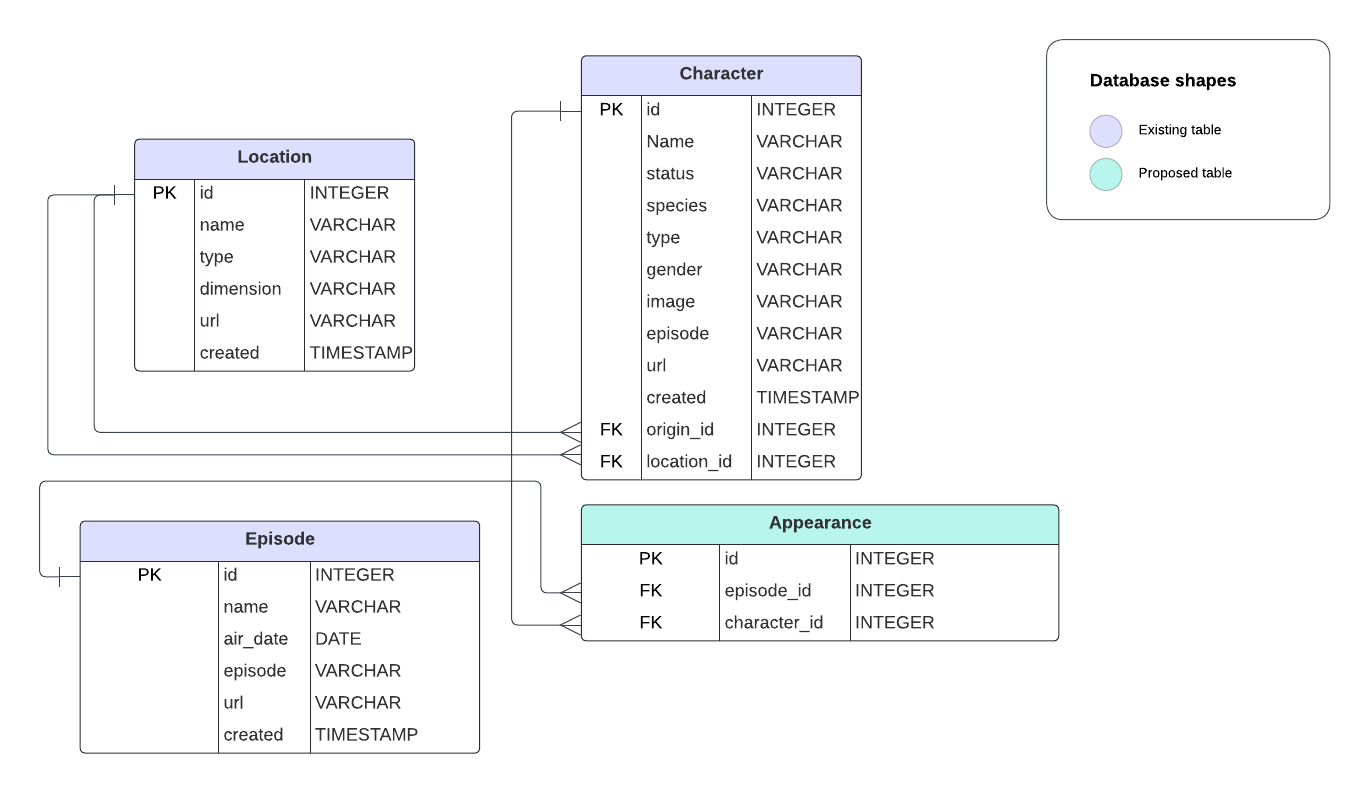


1. Lets read all the three Datasets we just Extracted and saved to our Untransformed Bucket in s3

In [40]:
bucket = "de-masterclass"  # S3 bucket name

# Read data from S3
print("Reading Character data from S3...")
characters_df = s3_ops.read_csv_from_s3(bucket, 'Rick&Morty/Untransformed/Character.csv')
print(f"Characters DataFrame shape: {characters_df.shape}")
print("Reading Episode data from S3...")
episodes_df = s3_ops.read_csv_from_s3(bucket, 'Rick&Morty/Untransformed/Episode.csv')
print(f"Characters DataFrame shape: {episodes_df.shape}")
print("Reading Location data from S3...")
location_df = s3_ops.read_csv_from_s3(bucket, 'Rick&Morty/Untransformed/Location.csv')
print(f"Locations DataFrame shape: {location_df.shape}")

# Check if data is loaded successfully
if characters_df is None or episodes_df is None or location_df is None:
    print("Error in loading data from S3")

print("Data loaded successfully from S3")



Reading Character data from S3...
Characters DataFrame shape: (826, 12)
Reading Episode data from S3...
Characters DataFrame shape: (51, 7)
Reading Location data from S3...
Locations DataFrame shape: (126, 7)
Data loaded successfully from S3


### 1. Characters Dataframe transformation
Here we will need to perform the following operations;
- Extract origin and location id values from the existing Location and origin columns. These columns consists of json records with key value pairs of locaton name and url respectively. To get the ids of these columns we will need to get the last numeric value from the url after the last back slash (/) of the url string.
- Once this is done we can now drop the original origin and location columns and retain the new ***origin_id*** and ***location_id*** which will now act as foreighn keys to our Location data.

In [41]:

origin_id_list = []
location_id_list = []

# Extracting location_id
for record in characters_df['origin']:
    # Parse the string into a dictionary if it's not already one
    if isinstance(record, str):
        record = ast.literal_eval(record)
    
    if record['url'] != '':
        origin_id = record['url'].split('/')[-1]  # Remove the unnecessary str() and just split
    else:
        origin_id = None

    origin_id_list.append(origin_id)
    
# extracting location_id
for record in characters_df['location']:
    # Parse the string into a dictionary if it's not already one
    if isinstance(record, str):
        record = ast.literal_eval(record)
    
    if record['url'] != '':
        location_id = record['url'].split('/')[-1]  # Remove the unnecessary str() and just split
    else:
        location_id = None
    location_id_list.append(location_id)

characters_df['origin_id'] = origin_id_list
characters_df['location_id'] = location_id_list


Alternatively.. we can use list comprehensions to solve for this in a simpler way

In [42]:

# Function to extract the ID from a URL
extract_id = lambda x: x.split('/')[-1] if x else None

# Using list comprehension to extract origin_id and location_id
characters_df['origin_id'] = [
    extract_id(ast.literal_eval(record)['url']) if isinstance(record, str) else None
    for record in characters_df['origin']
]

characters_df['location_id'] = [
    extract_id(ast.literal_eval(record)['url']) if isinstance(record, str) else None
    for record in characters_df['location']
]


In [43]:
# Drop and rename columns
print("Dropping and renaming columns...")
characters_df = characters_df.drop(columns=['origin', 'location', 'episode'])

Dropping and renaming columns...


In [44]:
characters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           826 non-null    int64 
 1   name         826 non-null    object
 2   status       826 non-null    object
 3   species      826 non-null    object
 4   type         425 non-null    object
 5   gender       826 non-null    object
 6   image        826 non-null    object
 7   url          826 non-null    object
 8   created      826 non-null    object
 9   origin_id    526 non-null    object
 10  location_id  805 non-null    object
dtypes: int64(1), object(10)
memory usage: 71.1+ KB


In [45]:
characters_df.head()

,id,name,status,species,type,gender,image,url,created,origin_id,location_id
0,1,Rick Sanchez,Alive,Human,NaN,Male,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/1,2017-11-04T18:48:46.250Z,1,3
1,2,Morty Smith,Alive,Human,NaN,Male,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/2,2017-11-04T18:50:21.651Z,None,3
2,3,Summer Smith,Alive,Human,NaN,Female,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/3,2017-11-04T19:09:56.428Z,20,20
3,4,Beth Smith,Alive,Human,NaN,Female,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/4,2017-11-04T19:22:43.665Z,20,20
4,5,Jerry Smith,Alive,Human,NaN,Male,https://rickandmortyapi.com/api/character/avat...,https://rickandmortyapi.com/api/character/5,2017-11-04T19:26:56.301Z,20,20


### 2. Appearance Dataframe Creation
Here we will need to perform the following operations;
- Load the Episodes df that will be our baseline table for the appearance dataframe
- Extract character ids from the character column that consists of a list of urls belonging to all characters that appeared in that particular episode
- Explode the resulting dataframe so that we now have each episode with its respective character as a new row.
- Reset the index of the resulting dataframe so as to generate a new incremental column that will act as the primary key of the new column
- Rename the new columns to resemble the proposed schema,
    1. new_index -> ***id***
    2. id -> ***episode_id***
    3. character_ids -> ***character_id***
- Once this is done we can now drop all other pre-existing columns that belonged to the episodes dataframe and only retain the three columns generated.

In [46]:
appearance_df = episodes_df.copy()

# Function to extract the ID from a URL
character_func = lambda x: [url.split('/')[-1] for url in ast.literal_eval(x)] if isinstance(x, str) else None

# Using list comprehension to extract character_ids
appearance_df['character_ids'] = [
    character_func(record) if record else None
    for record in appearance_df['characters']
]

# Explode the 'character_ids' column to create a row for each character ID
expanded_df = appearance_df.explode('character_ids')

# Reset the index to create a new 'id' column
expanded_df = expanded_df.reset_index(drop=True).reset_index().rename(columns={'index': 'id_new'})

# Rename columns to match the desired output
expanded_df = expanded_df.rename(columns={'id_new': 'id', 'id': 'episode_id', 'character_ids': 'character_id'})

# Select only the relevant columns
expanded_df = expanded_df[['id', 'episode_id', 'character_id']]

print(expanded_df.head())


   id  episode_id character_id
0   0           1            1
1   1           1            2
2   2           1           35
3   3           1           38
4   4           1           62


### 3. Episodes DataFrame transformation

Here we will only drop the original ***character*** column and retain all other pre-existing columns

In [47]:
# we can now safely drop the characters column from our Episodes dataframe
episodes_df = episodes_df.drop("characters", axis=1)
episodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        51 non-null     int64 
 1   name      51 non-null     object
 2   air_date  51 non-null     object
 3   episode   51 non-null     object
 4   url       51 non-null     object
 5   created   51 non-null     object
dtypes: int64(1), object(5)
memory usage: 2.5+ KB


### 4. Locations DataFrame transformation

Here we will only drop the original ***residents*** column and retain all other pre-existing columns

In [30]:
# Dropping Residents from Location Table
location_df = location_df.drop('residents', axis=1)
location_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         126 non-null    int64 
 1   name       126 non-null    object
 2   type       125 non-null    object
 3   dimension  124 non-null    object
 4   url        126 non-null    object
 5   created    126 non-null    object
dtypes: int64(1), object(5)
memory usage: 6.0+ KB


Finally we can now save our final 4 Dataframes to our Transformed Bucket in AWS s3

In [48]:
# Saving our final Dataframes to s3

# Character DataFrame
s3_ops.write_data_to_s3(characters_df, bucket, 'Rick&Morty/Transformed/Character.csv')
# Episodes DataFrame
s3_ops.write_data_to_s3(episodes_df, bucket, 'Rick&Morty/Transformed/Episode.csv')
# Appearance DataFrame
s3_ops.write_data_to_s3(expanded_df, bucket, 'Rick&Morty/Transformed/Appearance.csv')
# Location DataFrame
s3_ops.write_data_to_s3(location_df, bucket, 'Rick&Morty/Transformed/Location.csv')



Data saved to S3 with bucket_name: de-masterclass and key: Rick&Morty/Transformed/Character.csv
Data saved to S3 with bucket_name: de-masterclass and key: Rick&Morty/Transformed/Episode.csv
Data saved to S3 with bucket_name: de-masterclass and key: Rick&Morty/Transformed/Appearance.csv
Data saved to S3 with bucket_name: de-masterclass and key: Rick&Morty/Transformed/Location.csv


True